In [272]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [273]:
# Image completion
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [274]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


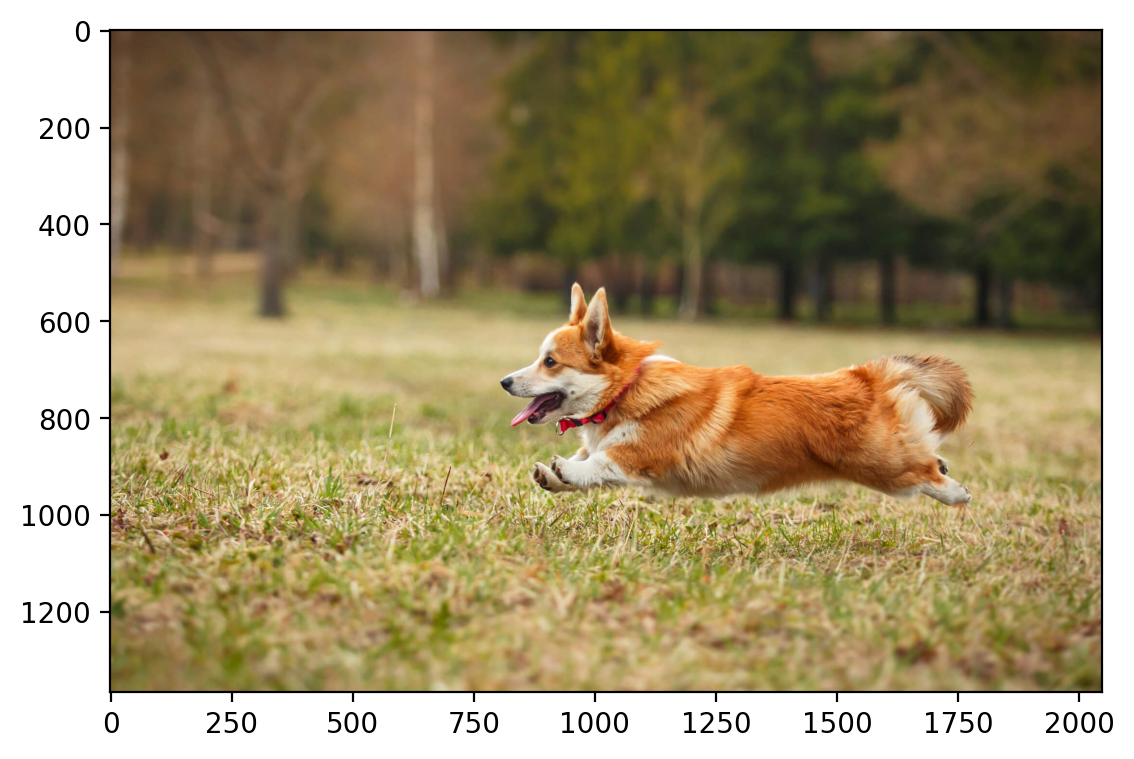

In [275]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

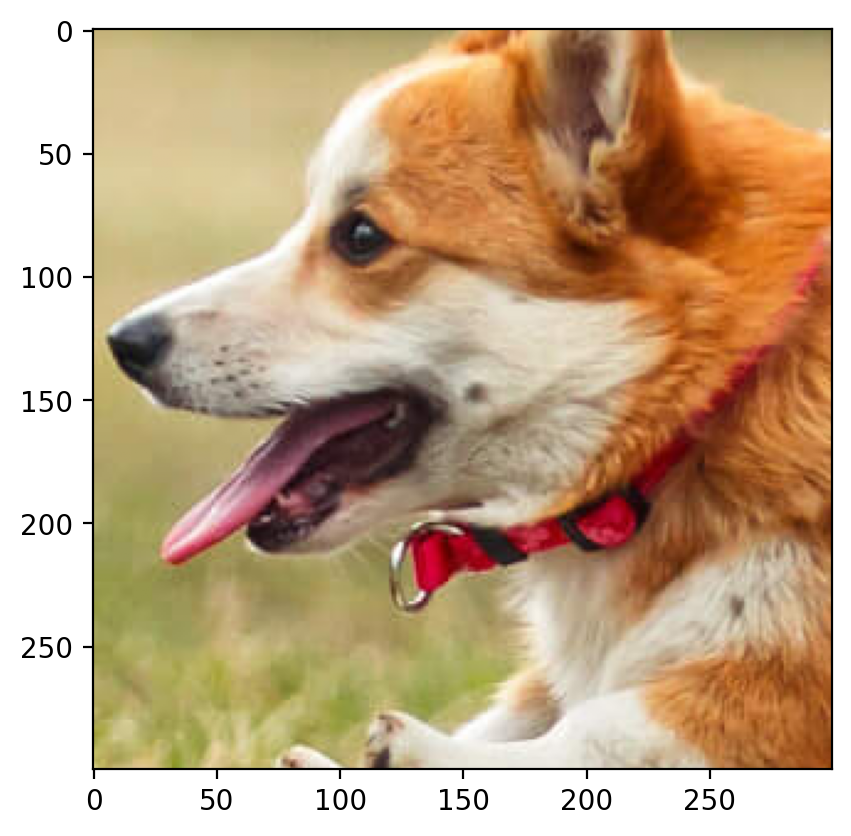

In [276]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler()
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [277]:
original_image = crop.clone()

In [278]:
def create_missing_patch_with_nan(img, start_h, start_w, patch_size):
    img_copy = img.clone()

    # Extract the patch from the image
    patch = img_copy[:, start_h:start_h+patch_size, start_w:start_w+patch_size].clone()

    # Check if the image is grayscale or color
    if len(img_copy.shape) == 2:  # Grayscale image
        img_copy[start_h:start_h+patch_size, start_w:start_w+patch_size] = float('nan')
    elif len(img_copy.shape) == 3:  # Color image
        img_copy[:, start_h:start_h+patch_size, start_w:start_w+patch_size] = float('nan')

    return img_copy, patch


In [279]:
img_with_missing_patch = create_missing_patch_with_nan(original_image, 0, 0, 50)

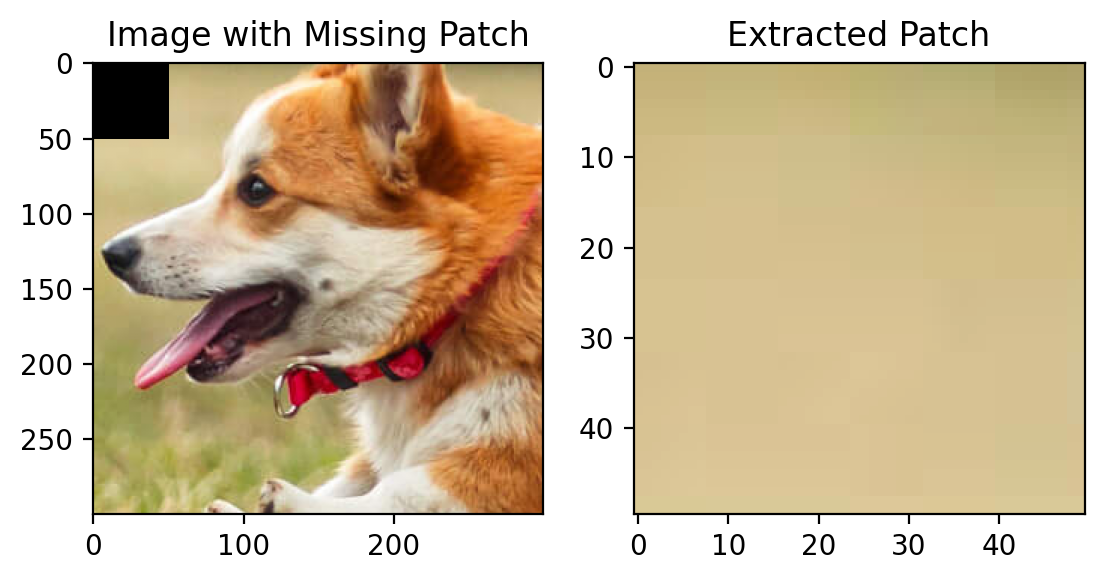

In [280]:
import matplotlib.pyplot as plt

# Assuming img_with_missing_patch is a tuple where the first element is the modified image and the second element is the patch
modified_image, patch = img_with_missing_patch

# Plot the modified image with the missing patch
plt.subplot(1, 2, 1)
plt.imshow(rearrange(modified_image, 'c h w -> h w c').cpu().numpy())
plt.title('Image with Missing Patch')

# Plot the extracted patch
plt.subplot(1, 2, 2)
plt.imshow(rearrange(patch, 'c h w -> h w c').cpu().numpy())
plt.title('Extracted Patch')

plt.show()


In [281]:
patch.shape

torch.Size([3, 50, 50])

In [282]:
reshaped_patch = patch.reshape(3, -1)

In [283]:
# reshaped_patch = reshaped_tensor.view(3, 50, 50)

# # Convert the tensor to an image
# to_pil = transforms.ToPILImage()
# image = to_pil(reshaped_patch)

# # Display the image
# plt.imshow(image)
# plt.axis('off')
# plt.show()

In [284]:
original_patch = patch.clone()

In [285]:
import torch.optim as optim


In [286]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix A into W and H
    A: input matrix of size (n_users, n_movies)
    k: number of latent features

    Returns W and H
    W: matrix of size (n_users, k)
    H: matrix of size (k, n_movies)
    """
    A = A.to(device)
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)

    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)

    # Train the model
    for i in range(1000):
        # Compute the loss
        loss = torch.norm(torch.mm(W, H) - A)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    return W, H, loss

In [287]:
W, H, loss = factorize(reshaped_patch, 10, device=device)

In [288]:
def get_reconstructed_matrix(W, H):
    """Get the reconstructed matrix from factors W and H"""
    return torch.mm(W, H)

# Example usage:
# After learning factors W and H using the factorize function
reconstructed_matrix = get_reconstructed_matrix(W, H)


In [289]:
reconstructed_matrix.shape

torch.Size([3, 2500])

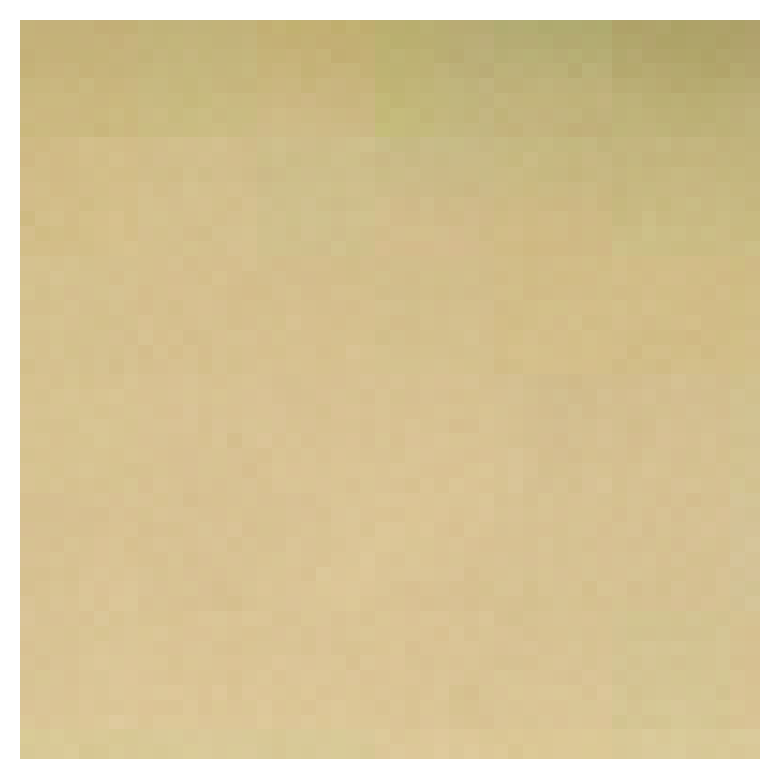

In [290]:
patch_reconstructed = reconstructed_matrix.view(3, 50, 50)

# Convert the tensor to an image
to_pil = transforms.ToPILImage()
image = to_pil(patch_reconstructed)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [291]:
def add_patch_to_image(modified_image, patch, start_h, start_w):
    image_with_patch = modified_image.clone()
    # Get the dimensions of the patch
    patch_c, patch_h, patch_w = patch.shape

    # Replace the NaN region in the image with the extracted patch
    image_with_patch[:, start_h:start_h+patch_h, start_w:start_w+patch_w] = patch

    return image_with_patch


5 0.8574973801154525
10 0.39479587820891116
25 0.48307624485228295
50 0.6626825187719502


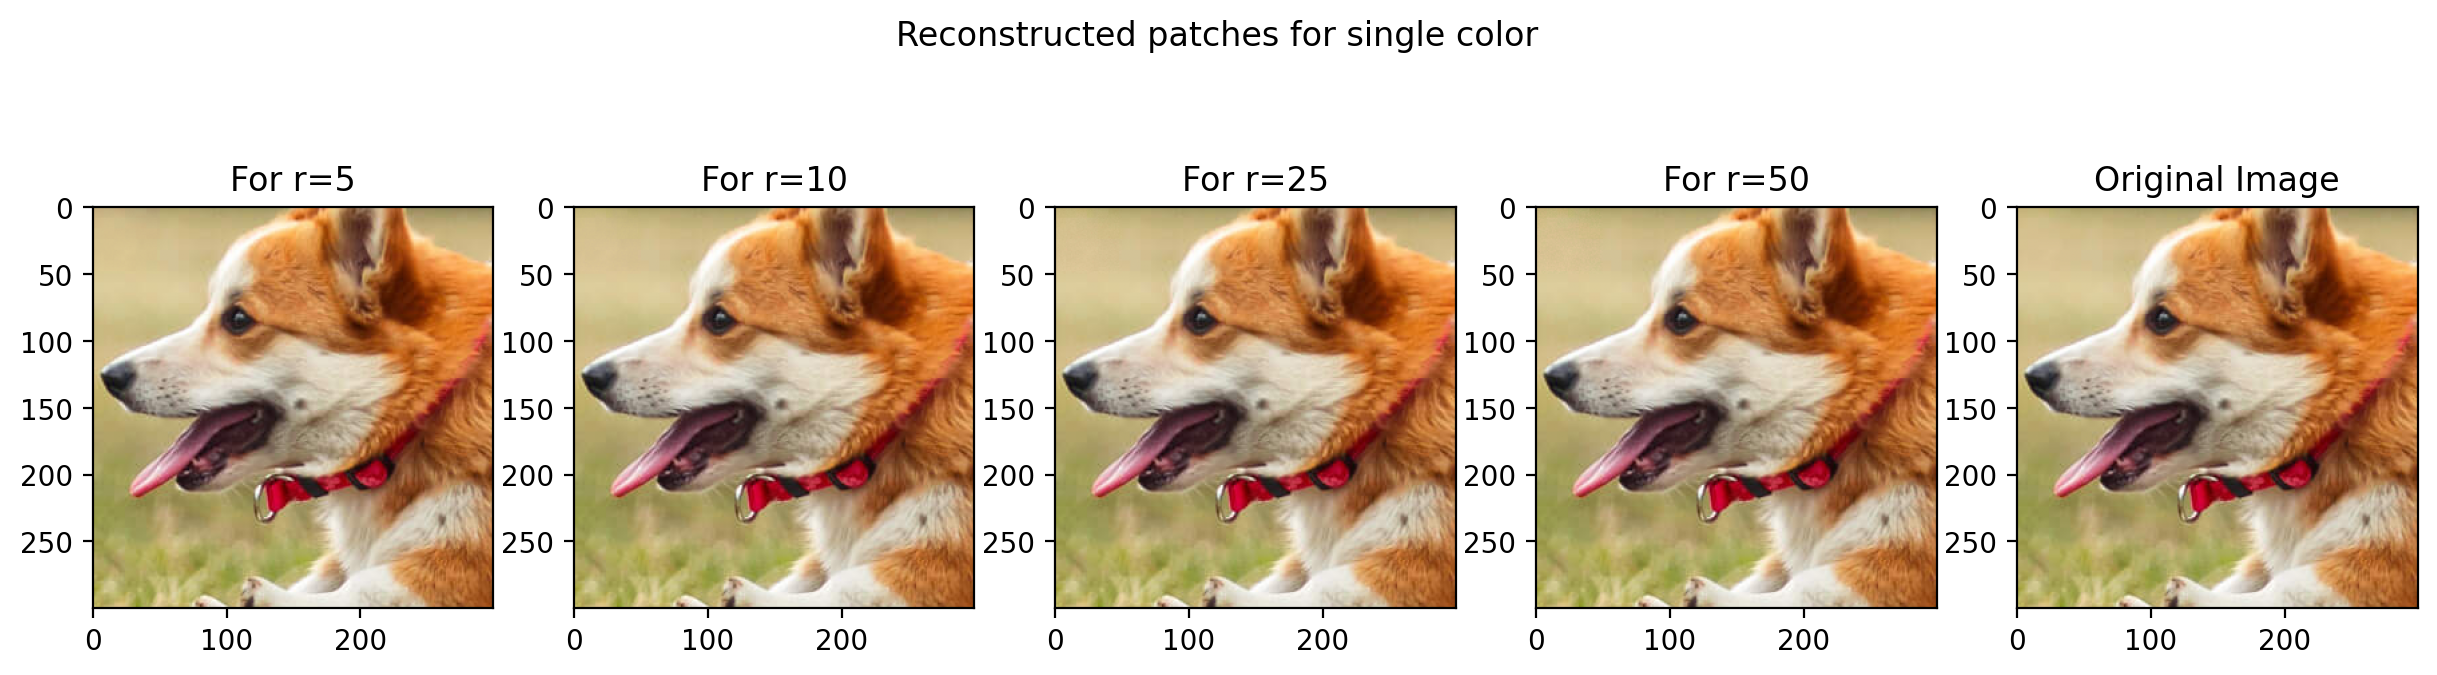

In [292]:
import matplotlib.pyplot as plt

k=[5,10,25,50]
label=["For r=5", "For r=10", "For r=25", "For r=50"]
reconstructed_patches = []
# Set the size of the figure
plt.figure(figsize=(15, 4))

# Loop over different values of k
for i in range(4):
    # Perform factorization
    W, H, loss = factorize(reshaped_patch, k[i], device=device)
    print(k[i], loss.item())

    # Reconstruct the patch
    reconstructed_matrix = get_reconstructed_matrix(W, H)
    patch_reconstructed = reconstructed_matrix.view(3, 50, 50)
    reconstructed_patches.append(patch_reconstructed)

    # Add the reconstructed patch to the modified image
    modified_image_with_patch = add_patch_to_image(modified_image, patch_reconstructed, 0, 0)

    # Plot the modified image with the reconstructed patch
    plt.subplot(1, 5, i+1)
    plt.imshow(rearrange(modified_image_with_patch.detach(), 'c h w -> h w c').cpu().numpy())
    plt.title(label[i])
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

# Plot the original image
plt.subplot(1, 5, 5)
plt.imshow(rearrange(original_image, 'c h w -> h w c').cpu().numpy())
plt.title('Original Image')
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

plt.suptitle('Reconstructed patches for single color')

# Show the plot
plt.show()


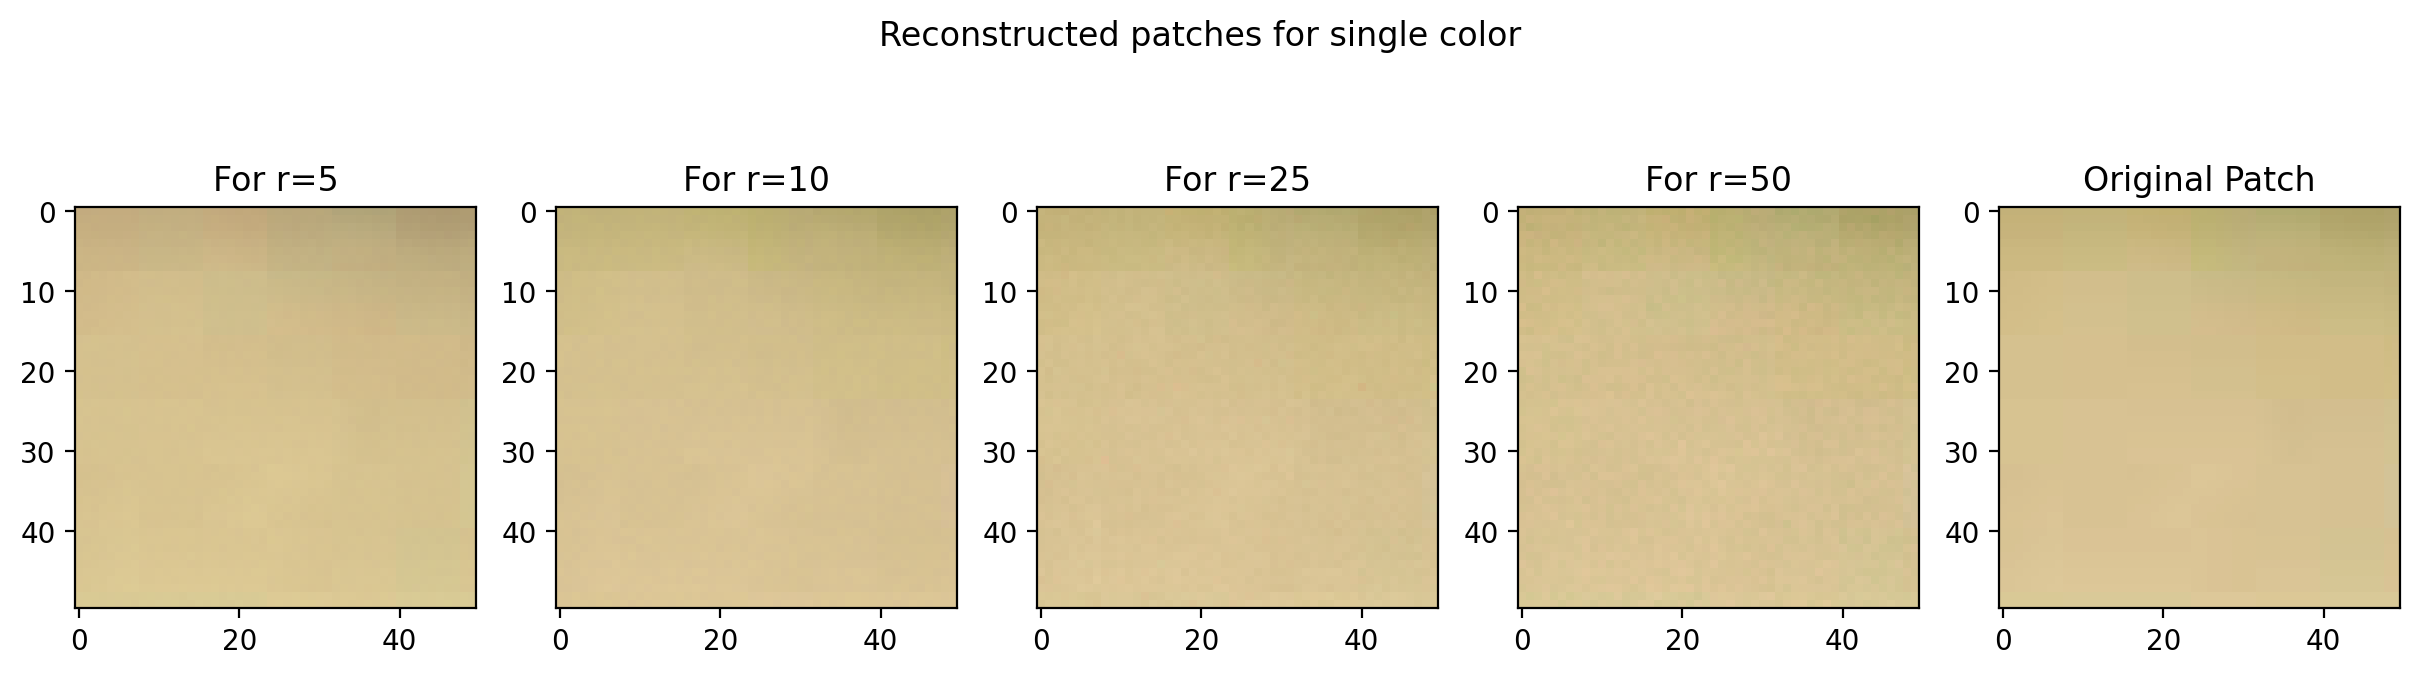

In [293]:
plt.figure(figsize=(15, 4))

for i in range(4):
  # Display the image

    to_pil = transforms.ToPILImage()
    image = to_pil(reconstructed_patches[i])

    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(label[i])
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal


# Plot the original image
plt.subplot(1, 5, 5)
plt.imshow(rearrange(patch, 'c h w -> h w c').cpu().numpy())
plt.title('Original Patch')
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

plt.suptitle('Reconstructed patches for single color')

# Show the plot
plt.show()

In [294]:
img_with_missing_patch = create_missing_patch_with_nan(original_image, 225, 250, 50)

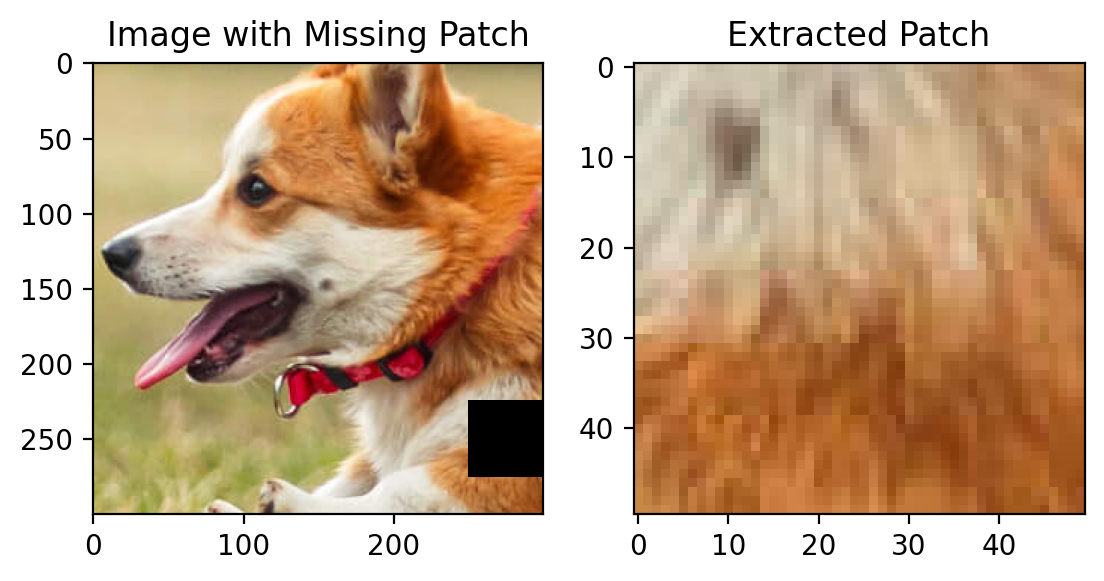

In [295]:
import matplotlib.pyplot as plt

# Assuming img_with_missing_patch is a tuple where the first element is the modified image and the second element is the patch
modified_image, patch = img_with_missing_patch

# Plot the modified image with the missing patch
plt.subplot(1, 2, 1)
plt.imshow(rearrange(modified_image, 'c h w -> h w c').cpu().numpy())
plt.title('Image with Missing Patch')

# Plot the extracted patch
plt.subplot(1, 2, 2)
plt.imshow(rearrange(patch, 'c h w -> h w c').cpu().numpy())
plt.title('Extracted Patch')

plt.show()

In [296]:
reshaped_patch = patch.reshape(3, -1)

5 0.4147223776379598
10 0.5043497399617294
25 0.7559811066975495
50 1.3410142508331633


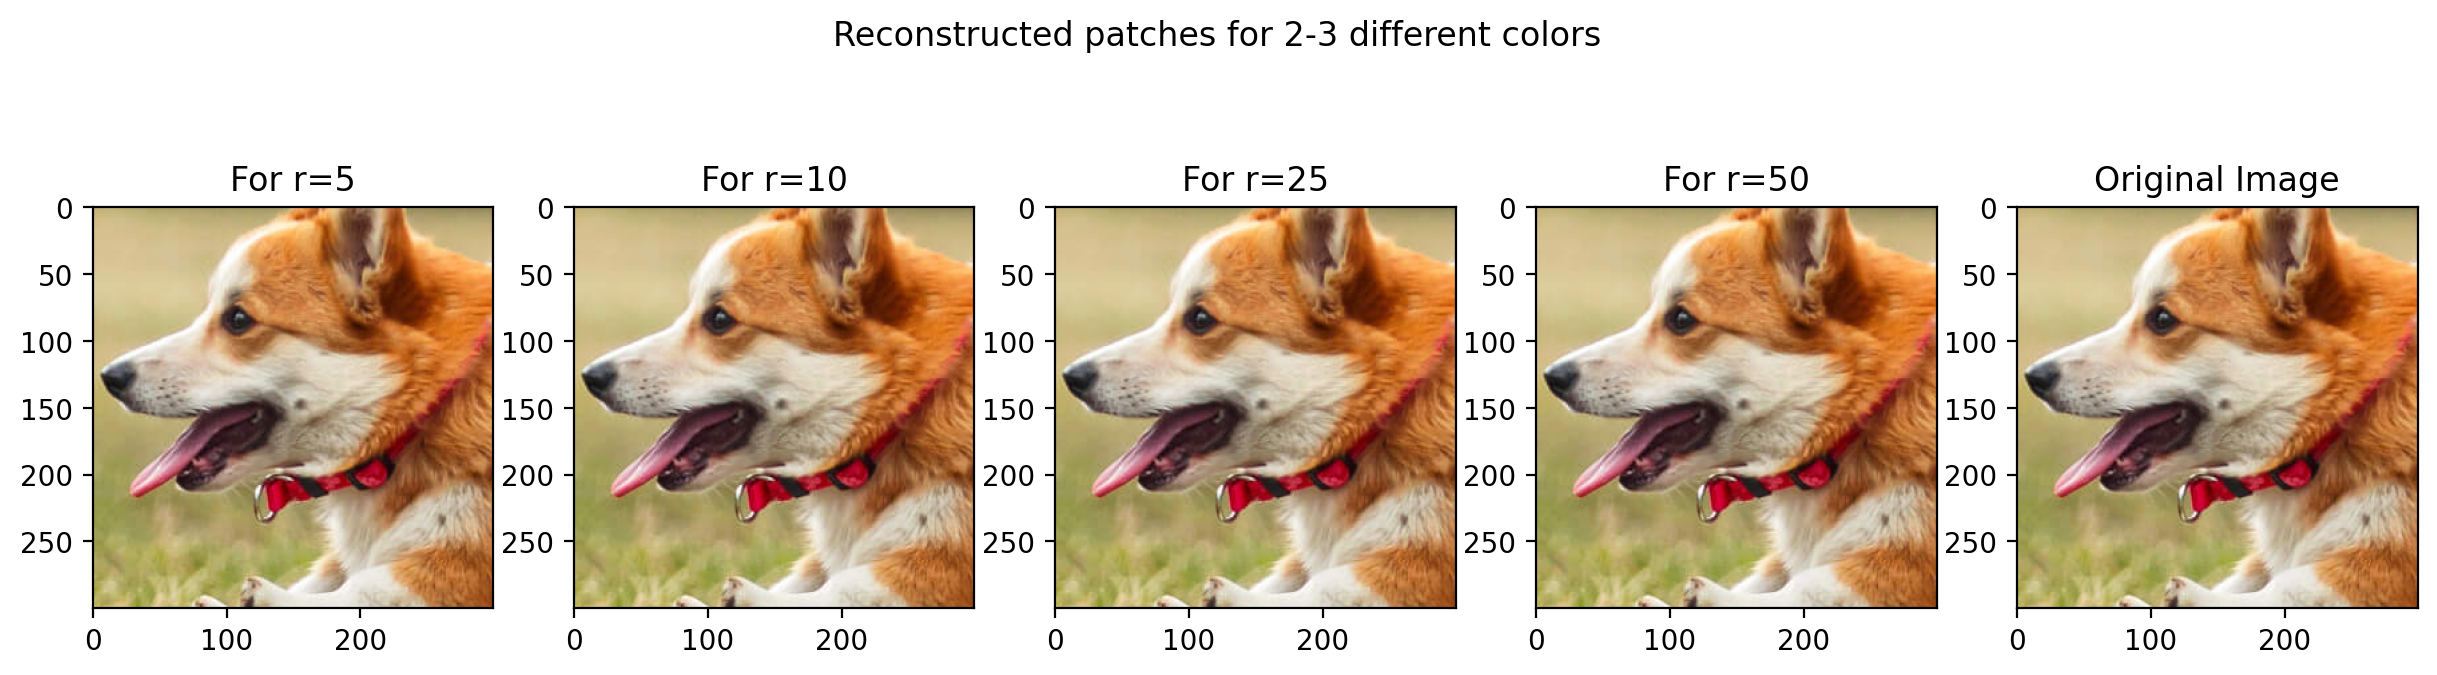

In [297]:
import matplotlib.pyplot as plt

k=[5,10,25,50]
label=["For r=5", "For r=10", "For r=25", "For r=50"]
reconstructed_patches = []
# Set the size of the figure
plt.figure(figsize=(15, 4))

# Loop over different values of k
for i in range(4):
    # Perform factorization
    W, H, loss = factorize(reshaped_patch, k[i], device=device)
    print(k[i], loss.item())

    # Reconstruct the patch
    reconstructed_matrix = get_reconstructed_matrix(W, H)
    patch_reconstructed = reconstructed_matrix.view(3, 50, 50)
    reconstructed_patches.append(patch_reconstructed)

    # Add the reconstructed patch to the modified image
    modified_image_with_patch = add_patch_to_image(modified_image, patch_reconstructed, 225, 250)

    # Plot the modified image with the reconstructed patch
    plt.subplot(1, 5, i+1)
    plt.imshow(rearrange(modified_image_with_patch.detach(), 'c h w -> h w c').cpu().numpy())
    plt.title(label[i])
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

# Plot the original image
plt.subplot(1, 5, 5)
plt.imshow(rearrange(original_image, 'c h w -> h w c').cpu().numpy())
plt.title('Original Image')
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

plt.suptitle('Reconstructed patches for 2-3 different colors')

# Show the plot
plt.show()

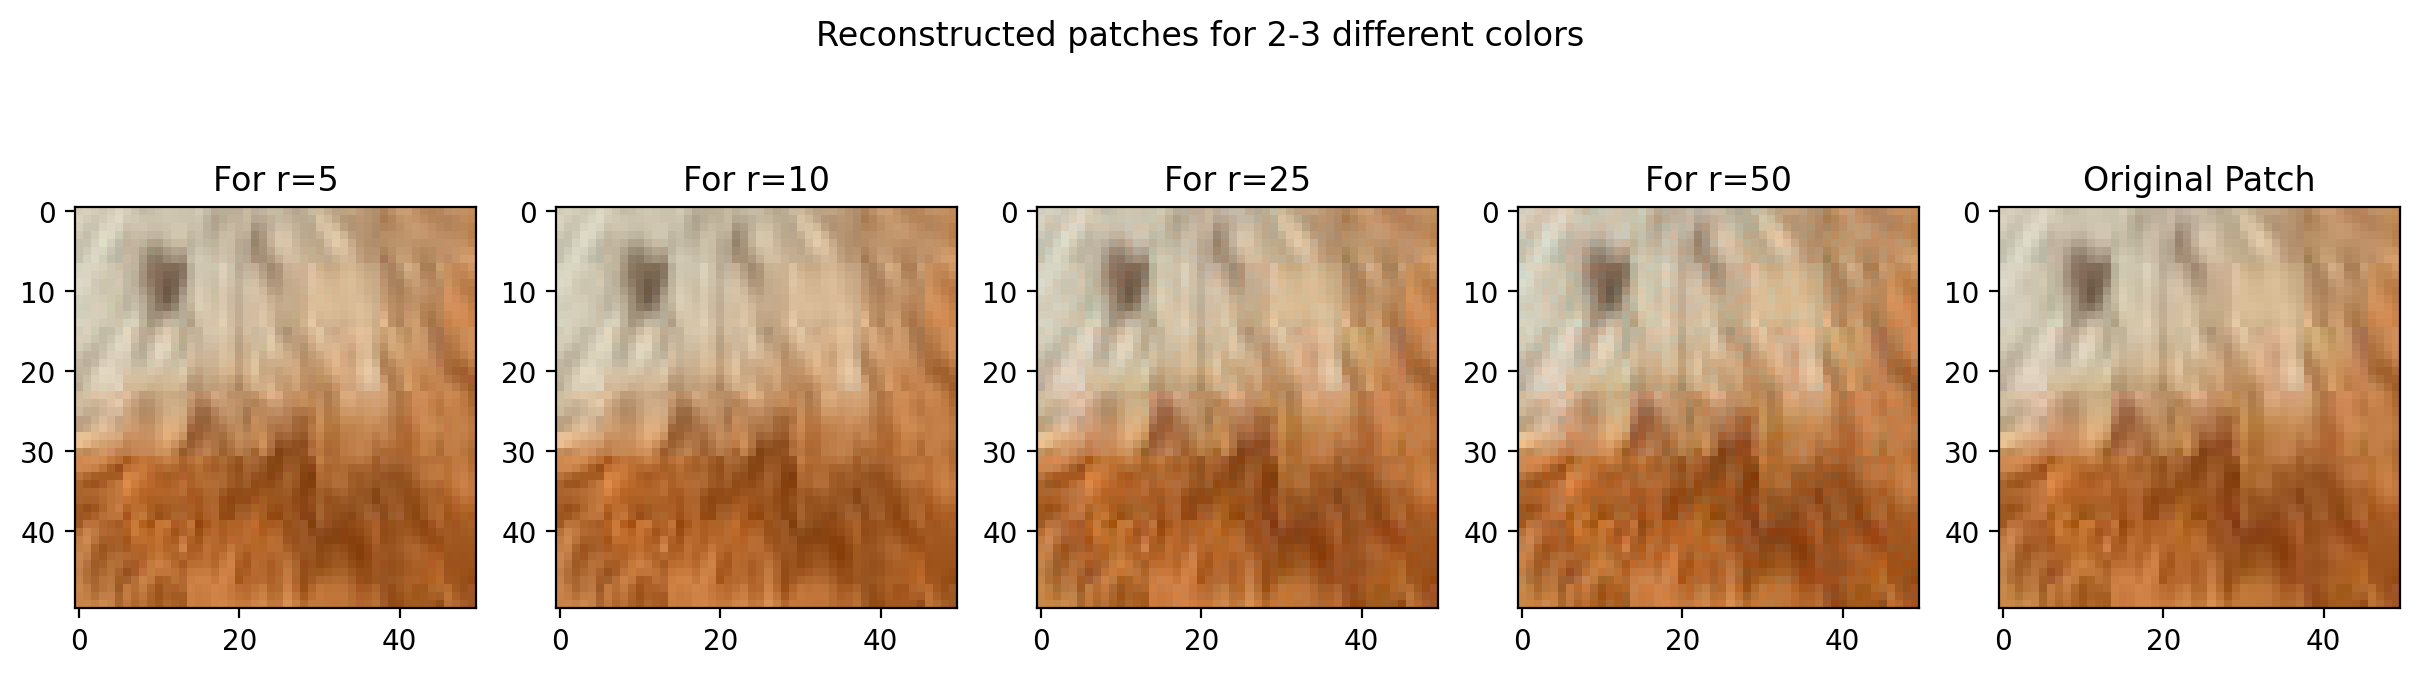

In [298]:
plt.figure(figsize=(15, 4))

for i in range(4):
  # Display the image

    to_pil = transforms.ToPILImage()
    image = to_pil(reconstructed_patches[i])

    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(label[i])
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal


# Plot the original image
plt.subplot(1, 5, 5)
plt.imshow(rearrange(patch, 'c h w -> h w c').cpu().numpy())
plt.title('Original Patch')
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

plt.suptitle('Reconstructed patches for 2-3 different colors')

# Show the plot
plt.show()

In [299]:
img_with_missing_patch = create_missing_patch_with_nan(original_image, 160, 100, 50)

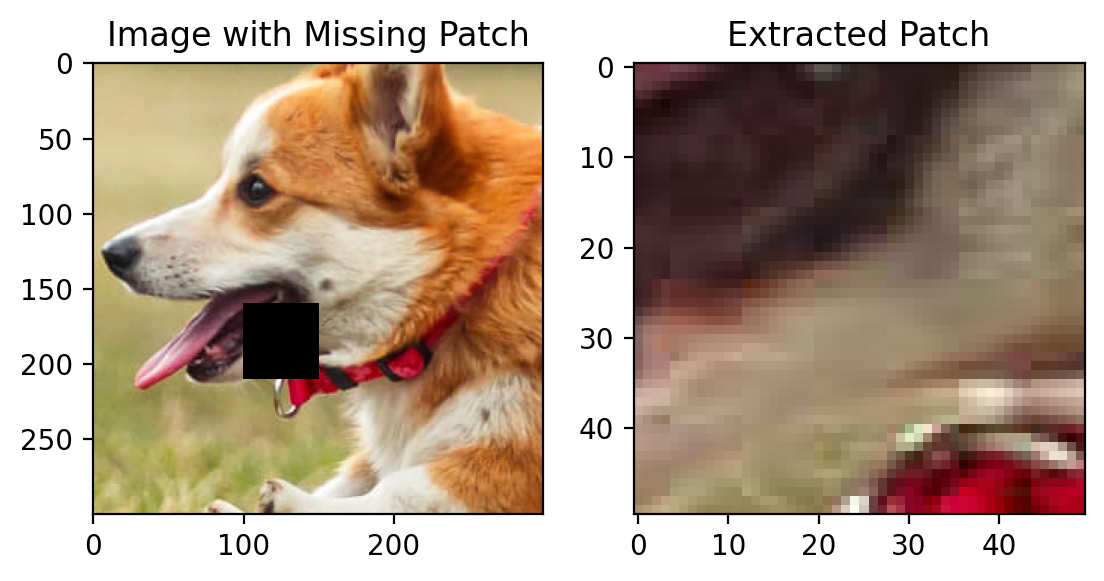

In [300]:
import matplotlib.pyplot as plt

# Assuming img_with_missing_patch is a tuple where the first element is the modified image and the second element is the patch
modified_image, patch = img_with_missing_patch

# Plot the modified image with the missing patch
plt.subplot(1, 2, 1)
plt.imshow(rearrange(modified_image, 'c h w -> h w c').cpu().numpy())
plt.title('Image with Missing Patch')

# Plot the extracted patch
plt.subplot(1, 2, 2)
plt.imshow(rearrange(patch, 'c h w -> h w c').cpu().numpy())
plt.title('Extracted Patch')

plt.show()

In [301]:
reshaped_patch = patch.reshape(3, -1)

5 1.1913193058984763


10 0.22558619654497894


25 0.452485383458487


50 1.260461361778588


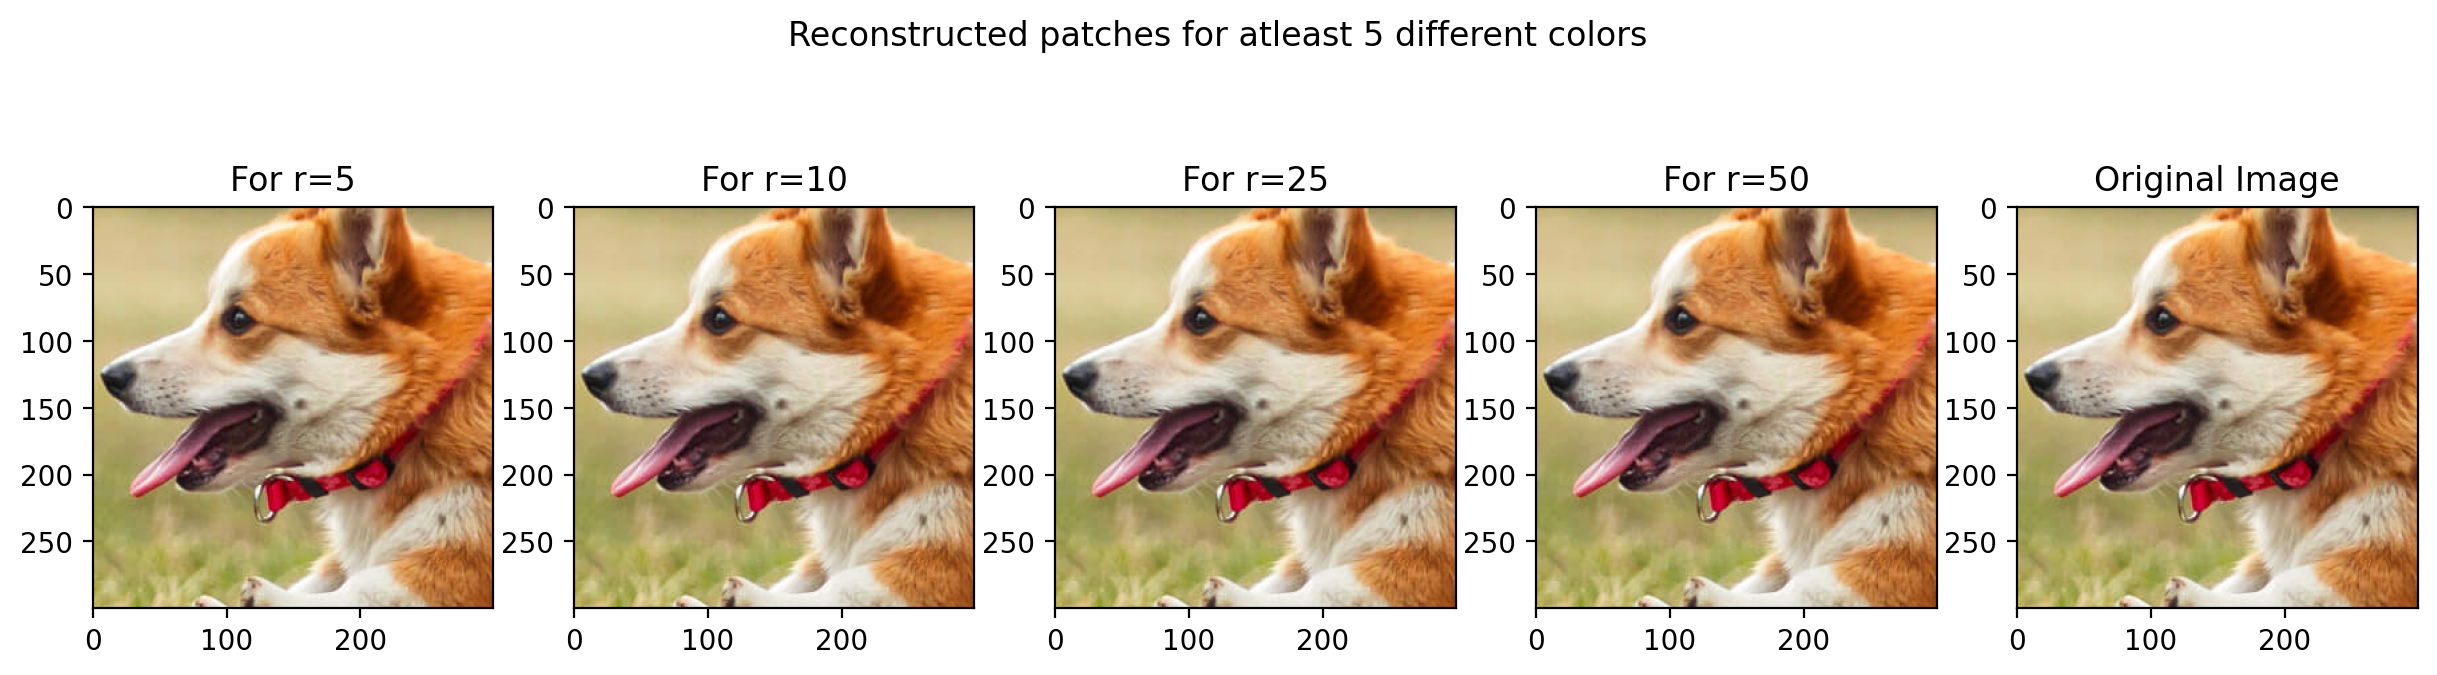

In [302]:
import matplotlib.pyplot as plt

k=[5,10,25,50]
label=["For r=5", "For r=10", "For r=25", "For r=50"]
reconstructed_patches = []

# Set the size of the figure
plt.figure(figsize=(15, 4))

# Loop over different values of k
for i in range(4):
    # Perform factorization
    W, H, loss = factorize(reshaped_patch, k[i], device=device)
    print(k[i], loss.item())

    # Reconstruct the patch
    reconstructed_matrix = get_reconstructed_matrix(W, H)
    patch_reconstructed = reconstructed_matrix.view(3, 50, 50)
    reconstructed_patches.append(patch_reconstructed)

    # Add the reconstructed patch to the modified image
    modified_image_with_patch = add_patch_to_image(modified_image, patch_reconstructed, 160, 100)

    # Plot the modified image with the reconstructed patch
    plt.subplot(1, 5, i+1)
    plt.imshow(rearrange(modified_image_with_patch.detach(), 'c h w -> h w c').cpu().numpy())
    plt.title(label[i])
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

# Plot the original image
plt.subplot(1, 5, 5)
plt.imshow(rearrange(original_image, 'c h w -> h w c').cpu().numpy())
plt.title('Original Image')
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

plt.suptitle('Reconstructed patches for atleast 5 different colors')

# Show the plot
plt.show()

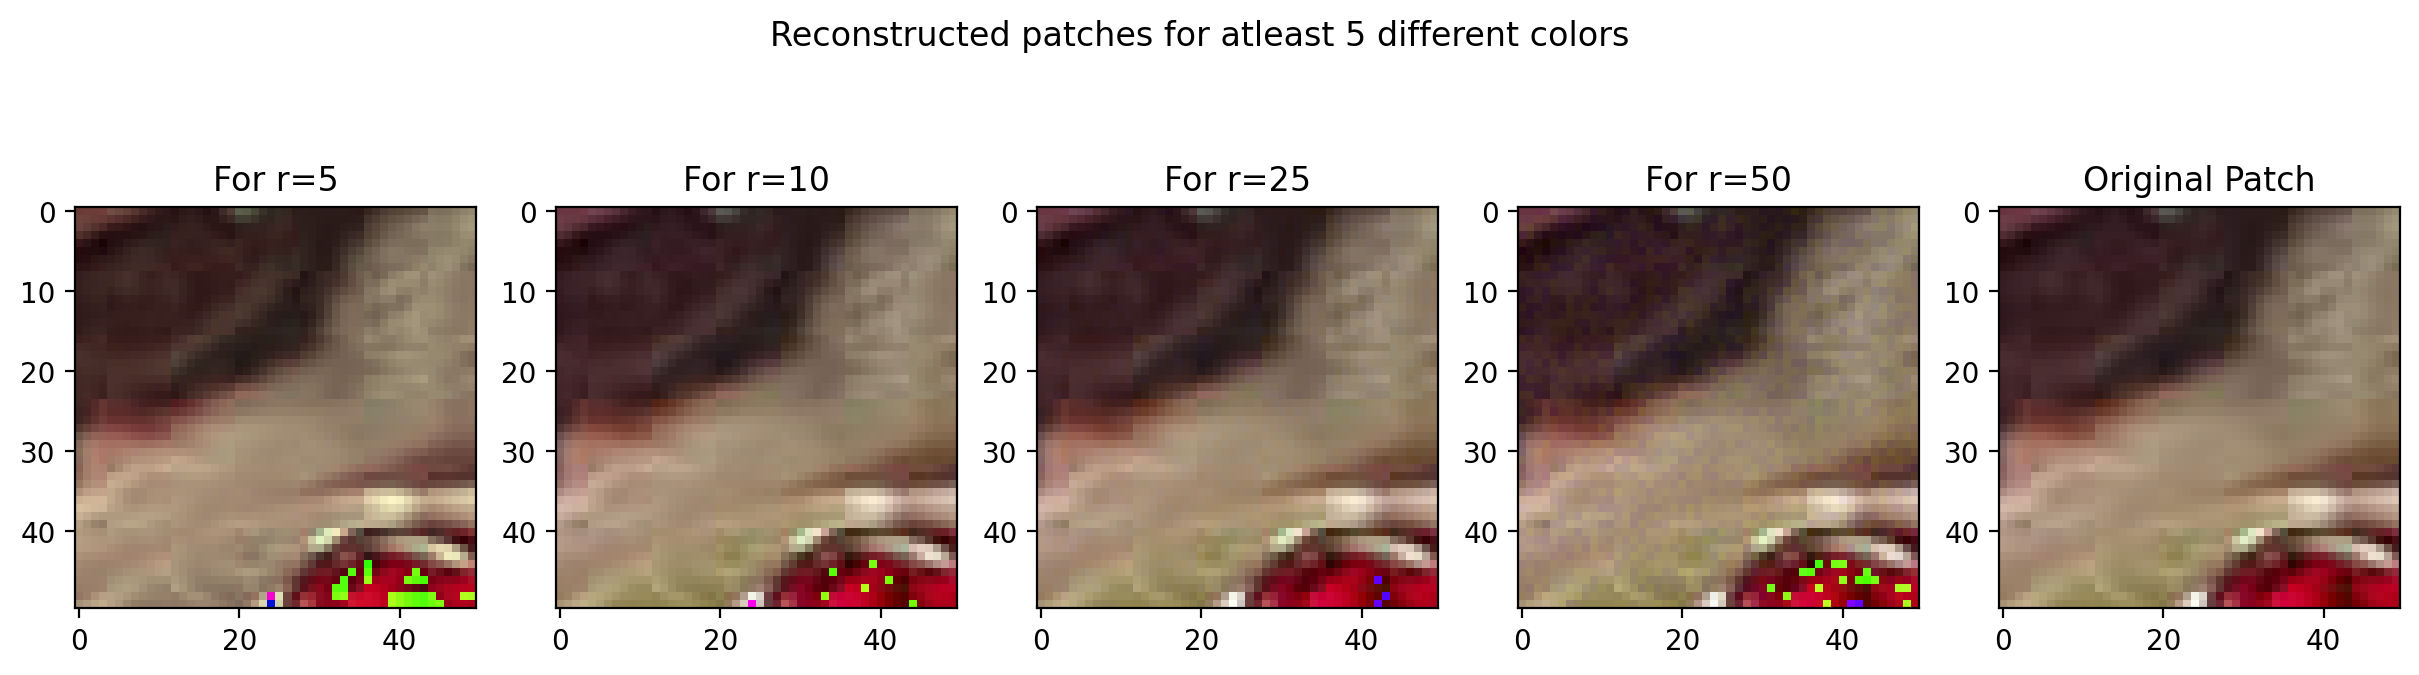

In [303]:
plt.figure(figsize=(15, 4))

for i in range(4):
  # Display the image

    to_pil = transforms.ToPILImage()
    image = to_pil(reconstructed_patches[i])

    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(label[i])
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal


# Plot the original image
plt.subplot(1, 5, 5)
plt.imshow(rearrange(patch, 'c h w -> h w c').cpu().numpy())
plt.title('Original Patch')
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

plt.suptitle('Reconstructed patches for atleast 5 different colors')

# Show the plot
plt.show()